In [4]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

# SAC Continuous

In [ ]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, action_dim)
        self.fc_std = nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = torch.distributions.Normal(mu, std)
        normal_sample = dist.rsample()
        log_prob = dist.log_prob(normal_sample)
        action = torch.tanh(normal_sample)
        log_prob = log_prob - torch.log(1 - action.pow(2) + 1e-7)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        action = action * self.action_bound
        return action, log_prob

class QValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNetContinuous, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        return self.net(x)
    

In [ ]:
class SACContinuous:
    """ SAC (Soft Actor-Critic) for continuous action spaces """
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 action_bound,
                 actor_lr,
                 critic_lr,
                 alpha_lr,
                 target_entropy,
                 tau,
                 gamma,
                 device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)

        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)

        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)

        self.target_entropy = target_entropy
        self.gamma = gamma
        self.tau = tau
        self.device = device
    
    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        action = self.actor(state)[0]
        return [action.item()]
    
    def calc_target(self, rewards, next_states, dones):
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (~dones.bool()).float()
        return td_target
    
    def soft_update(self, net, target_net):
        for param, target_param in zip(net.parameters(), target_net.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

    def update(self, transition_dict):
        torch.autograd.set_detect_anomaly(True)
        states = torch.tensor(np.array(transition_dict['states']), dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(transition_dict['actions']), dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']), dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']), dtype=torch.float).to(self.device)
        dones = torch.tensor(np.array(transition_dict['dones']), dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0

        # Update Critic Net(Two Q-value Net)
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_loss = F.mse_loss(self.critic_1(states, actions), td_target.detach())
        critic_2_loss = F.mse_loss(self.critic_2(states, actions), td_target.detach())
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # Update Actor Net (Policy Net)
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update Alpha
        # log_prob_for_alpha = log_prob.detach()
        # entropy_for_alpha = -log_prob_for_alpha
        alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        # Soft Update Target Net
        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

In [40]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]

seed = 0
env.reset(seed=seed)
env.action_space.seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.99
tau = 0.005
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -env.action_space.shape[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = SACContinuous(state_dim,
                      hidden_dim,
                      action_dim,
                      action_bound,
                      actor_lr,
                      critic_lr,
                      alpha_lr,
                      target_entropy,
                      tau,
                      gamma,
                      device)

In [41]:
return_list = rl_utils.train_off_policy_agent(env,
                                              agent,
                                              num_episodes,
                                              replay_buffer,
                                              minimal_size,
                                              batch_size)

Iteration 0:   0%|          | 0/10 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 9: 100%|██████████| 10/10 [00:37<00:00,  3.78s/it, episode=100, return=-230.129]


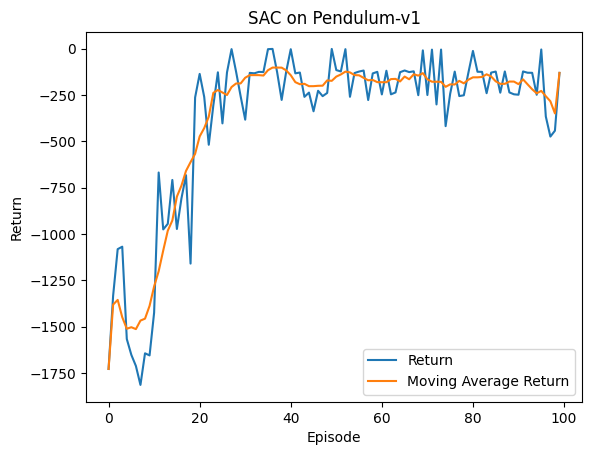

In [42]:
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(return_list, label='Return')
plt.plot(mv_return, label='Moving Average Return')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('SAC on {}'.format(env_name))
plt.show()

In [43]:
score = rl_utils.moving_average_score(return_list)
print(score)

-230.12911005353513


In [44]:
rl_utils.watch_agent(env_name,
                     agent,
                     device,
                     num_episodes=1)

/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [45]:
rl_utils.record_multiple_episodes(env_name,
                                  agent,
                                  device,
                                  num_episodes=1,
                                  videos_per_row=1,
                                  filename='sac_pendulum(v1)_r1',
                                  score=score)
rl_utils.record_multiple_episodes(env_name,
                                  agent,
                                  device,
                                  num_episodes=10,
                                  videos_per_row=5,
                                  filename='sac_pendulum(v1)_r10',
                                  score=score)

/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


MoviePy - Building file ./video/sac_pendulum(v1)_r1_score-230.13_20250503-060114.gif with imageio.


✅ Video saved at ./video/sac_pendulum(v1)_r1_score-230.13_20250503-060114.gif
MoviePy - Building file ./video/sac_pendulum(v1)_r10_score-230.13_20250503-060118.gif with imageio.


✅ Video saved at ./video/sac_pendulum(v1)_r10_score-230.13_20250503-060118.gif


In [47]:
agent_dict = {
    'actor': agent.actor,
    'critic_1': agent.critic_1,
    'critic_2': agent.critic_2,
    'target_critic_1': agent.target_critic_1,
    'target_critic_2': agent.target_critic_2
}
rl_utils.save_all(agent_dict=agent_dict,
                  return_list=return_list,
                  model_name='sac_pendulum(v1)',
                  mv_return=mv_return,
                  score=score)

✅ Multi-agents saved at ./agent/sac_pendulum(v1)_score-230.13_20250503-060454.pth
📝 Save log updated at ./agent/save_log.json
✅ Return list saved at ./results/sac_pendulum(v1)_score-230.13_20250503-060454_return_list.pkl
📈 Return curve saved at ./results/sac_pendulum(v1)_score-230.13_20250503-060454_return_curve.png


# SAC Discrete

In [5]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=1)
        )
    
    def forward(self, state):
        return self.net(state)

class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
    
    def forward(self, state):
        return self.net(state)

In [6]:
class SAC:
    """ SAC (Soft Actor-Critic) for discrete action spaces """
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 actor_lr,
                 critic_lr,
                 alpha_lr,
                 target_entropy,
                 tau,
                 gamma,
                 device):
        
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device)

        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)

        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)

        self.target_entropy = target_entropy
        self.gamma = gamma 
        self.tau = tau
        self.device = device
    
    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
    
    def calc_target(self, rewards, next_states, dones):
        next_probs = self.actor(next_states)
        next_log_probs = torch.log(next_probs + 1e-8)
        entropy = -torch.sum(next_probs * next_log_probs, dim=1, keepdim=True)
        q1_value = self.target_critic_1(next_states)
        q2_value = self.target_critic_2(next_states)
        min_qvalue = torch.sum(next_probs * torch.min(q1_value, q2_value), dim=1, keepdim=True)
        td_target = rewards + self.gamma * (min_qvalue + self.log_alpha.exp() * entropy) * (~dones.bool()).float()
        return td_target
    
    def soft_update(self, net, target_net):
        for param, param_target in zip(net.parameters(), target_net.parameters()):
            param_target.data.copy_(self.tau * param.data + (1.0 - self.tau) * param_target.data)
        
    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']), dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(transition_dict['actions']), dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']), dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']), dtype=torch.float).to(self.device)
        dones =torch.tensor(np.array(transition_dict['dones']), dtype=torch.float).view(-1, 1).to(self.device)

        # Update Critic Net(Two Q-value Net)
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_loss = F.mse_loss(self.critic_1(states).gather(1, actions), td_target.detach())
        critic_2_loss = F.mse_loss(self.critic_2(states).gather(1, actions), td_target.detach())
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # Update Actor Net (Policy Net)
        probs = self.actor(states)
        log_probs = torch.log(probs + 1e-8)
        entropy = -torch.sum(probs * log_probs, dim=1, keepdim=True)
        q1_value = self.critic_1(states)
        q2_value = self.critic_2(states)
        min_qvalue = torch.sum(probs * torch.min(q1_value, q2_value), dim=1, keepdim=True)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - min_qvalue)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update Alpha
        alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        # Soft Update Target Net
        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)


In [ ]:
actor_lr = 1e-3
critic_lr = 1e-2
alpha_lr = 1e-3
num_episodes = 200
hidden_dim = 128
gamma = 0.98
tau = 0.005
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)

seed = 0
env.reset(seed=seed)
env.action_space.seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
target_entropy = -1

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = SAC(state_dim,
            hidden_dim,
            action_dim,
            actor_lr,
            critic_lr,
            alpha_lr,
            target_entropy,
            tau,
            gamma,
            device)


In [56]:
return_list = rl_utils.train_off_policy_agent(env,
                                              agent,
                                              num_episodes,
                                              replay_buffer,
                                              minimal_size,
                                              batch_size)

Iteration 9: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s, episode=200, return=156.100]


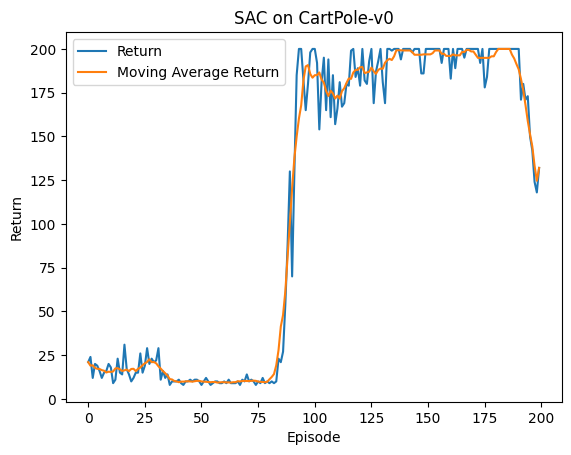

In [57]:
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(return_list, label='Return')
plt.plot(mv_return, label='Moving Average Return')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('SAC on {}'.format(env_name))
plt.show()

In [50]:
rl_utils.watch_agent(env_name,
                     agent,
                     device,
                     num_episodes=1)

In [58]:
score = rl_utils.moving_average_score(return_list)
print(score)

156.1


In [59]:
rl_utils.record_multiple_episodes(env_name,
                                  agent,
                                  device,
                                  num_episodes=1,
                                  videos_per_row=1,
                                  filename='sac_cartpole(v0)_r1',
                                  score=score)
rl_utils.record_multiple_episodes(env_name,
                                  agent,
                                  device,
                                  num_episodes=10,
                                  videos_per_row=5,
                                  filename='sac_cartpole(v0)_r10',
                                  score=score)

MoviePy - Building file ./video/sac_cartpole(v0)_r1_score156.10_20250503-184813.gif with imageio.


✅ Video saved at ./video/sac_cartpole(v0)_r1_score156.10_20250503-184813.gif
MoviePy - Building file ./video/sac_cartpole(v0)_r10_score156.10_20250503-184815.gif with imageio.


✅ Video saved at ./video/sac_cartpole(v0)_r10_score156.10_20250503-184815.gif


In [60]:
agent_dict = {
    'actor': agent.actor,
    'critic_1': agent.critic_1,
    'critic_2': agent.critic_2,
    'target_critic_1': agent.target_critic_1,
    'target_critic_2': agent.target_critic_2
}
rl_utils.save_all(agent_dict=agent_dict,
                  return_list=return_list,
                  model_name='sac_cartpole(v0)',
                  mv_return=mv_return,
                  score=score)

✅ Multi-agents saved at ./agent/sac_cartpole(v0)_score156.10_20250503-184850.pth
📝 Save log updated at ./agent/save_log.json
✅ Return list saved at ./results/sac_cartpole(v0)_score156.10_20250503-184850_return_list.pkl
📈 Return curve saved at ./results/sac_cartpole(v0)_score156.10_20250503-184850_return_curve.png
